<a href="https://colab.research.google.com/github/delhian/NLP_course/blob/master/text_classification/3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Классификация текстов</center></h1>

Сегодня мы подробнее познакомимся с задачей классификации текстов на два или более классов.

У нас есть [набор данных отзывов на фильмы IMDB](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), который часто используют при разработке и оценке моделей классификации текстов. Каждый из отзывов в наборе данных имеет свою оценку: является ли он позитивным или негативным.

**Цель:** Используя данные отзывов IMDB, построить модель, которая на основе текста отзыва сможет определять, относится ли он к позитивнму или к негативному классу.

## План работы
* Подготовка данных
* Классификация с помощью Word2Vec:
    * Обучение модели Word2Vec
    * Построение векторов для текстов через среднее векторов слов
    * Построение векторов для текстов через средневзвешенное векторов слов
* Классификация с помощью FastText
* Классификация с помощью сверточной нейронной сети (CNN)

## Подготовка данных



Для обучения нейросетевых моделей (далее) мы будем использовать популярный фреймворк [PyTorch](https://pytorch.org/).

В предположении, что PyTorch уже установлен, поставим дополнительные модули (torchvision и torchtext) и загрузим модель для токенизации:

In [1]:
!pip install torchvision

In [2]:
!pip install torchtext

Загрузим датасет IMDB из torchtext, это будет удобно для дальнейшего использования этих данных при обучении нейронной сети.

In [34]:
import numpy as np
import torch
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report,confusion_matrix
from torchtext.legacy import data
from torchtext import datasets
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter,defaultdict
%matplotlib inline
import seaborn as sns

print(torch.__version__)

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField()

Разделим данные на обучаующую и тестовую выборку и преобразуем их в формат, удобный для построения классических моделей машинного обучения.

In [82]:
%%time

train_src, test = datasets.IMDB()

X_train, X_test, y_train, y_test = [], [], [], []

def tokenize(line):
    return line.split()

for label, line in train_src:
  X_train.append(tokenize(line))
  y_train.append(label)

for label, line in test:
  X_test.append(tokenize(line))
  y_test.append(label)

CPU times: user 23.1 s, sys: 2.27 s, total: 25.3 s
Wall time: 25.2 s


In [83]:
from collections import Counter

print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

train_counter = Counter(y_train)
test_counter = Counter(y_test)

print ("{0} positive and {1} negative examples in test".format(test_counter['pos'],test_counter['neg']))
print ("{0} positive and {1} negative examples in test".format(test_counter['pos'],test_counter['neg']))

total train examples 25000
total test examples 25000
12500 positive and 12500 negative examples in test
12500 positive and 12500 negative examples in test


Можно видеть, что классы сбалансированы: количество позитивных и негативных отзывов совпадают.

Посмотрим на примеры позитивного и негативного отзыва.

In [86]:
print("Negative example:\n{0}\n\n".format(' '.join(X_train[0])))
print("Positive example:\n{0}\n\n".format(' '.join(X_train[-1])))

Negative example:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few an

## Классификация с помощью Word2Vec

Подробно языковая модель *Word2Vec* была рассмотрена на предыдущей неделе курса.

Здесь мы будем использовать эту модель для получения векторных представлений слов.

In [89]:
from gensim.models import Word2Vec
model = Word2Vec(X_train, size=100, window=5, min_count=5, workers=4)
model.save("word2vec.model")

In [90]:
w2v_model = Word2Vec.load("word2vec.model")

Чтобы решить задачу классификации текстов, нам нужно каждому тексту поставить в соответствие вектор.

Реализуем класс *MeanEmbeddingVectorizer*, с помощью которого будем получать вектора для текстов отзывов на основе векторов слов.
Вектор каждого текста будет равен среднему векторов входящих в него слов.

In [92]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Попробуем также немного другой подход $-$ будем получать вектор для текста как средневзвешенное векторов входящих в него слов с весами *tf-idf*.

Для этого реализуем класс *TfidfEmbeddingVectorizer*.

In [93]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Преобразуем модель Word2Vec в словарь для дальнейшего использования для векторизации текстов.

In [94]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


Для классификации будем использовать модель [случайного леса](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) из scikit-learn.

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [96]:
%time rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

CPU times: user 11 s, sys: 50 ms, total: 11.1 s
Wall time: 11 s


Построим отчет по предсказаниям модели (с помощью MeanEmbeddingVectorizer) на тестовой выборке. Выведем точность (precision), полноту (recall) и f1-меру для позитивного и негативного классов, а также количество объектов каждого класса (support) в тестовой выборке.

Precision:   0.70
Recall:   0.70
F1-measure:   0.69
Accuracy:   0.70
              precision    recall  f1-score   support

         neg       0.68      0.75      0.71     12500
         pos       0.72      0.64      0.68     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.69     25000
weighted avg       0.70      0.70      0.69     25000



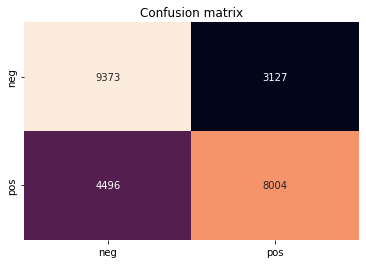

In [97]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

В данном случае классы сбалансированы (количество объектов позитивного и негативного классов совпадают), поэтому в качестве метрики качества можно использовать *accuracy*.

In [98]:
%time rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

CPU times: user 9min 2s, sys: 40.8 s, total: 9min 43s
Wall time: 9min 40s


Теперь выведем результаты работы классификатора на признаках из *TfidfEmbeddingVectorizer*.

Precision:   0.72
Recall:   0.72
F1-measure:   0.72
Accuracy:   0.72
              precision    recall  f1-score   support

         neg       0.70      0.77      0.73     12500
         pos       0.74      0.67      0.70     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000



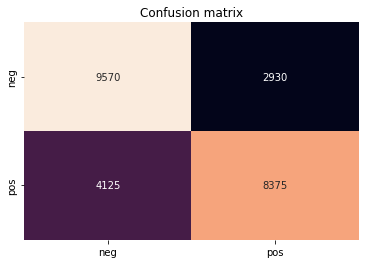

In [100]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Precision:   0.72
Recall:   0.72
F1-measure:   0.72
Accuracy:   0.72
              precision    recall  f1-score   support

         neg       0.70      0.77      0.73     12500
         pos       0.74      0.67      0.70     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000



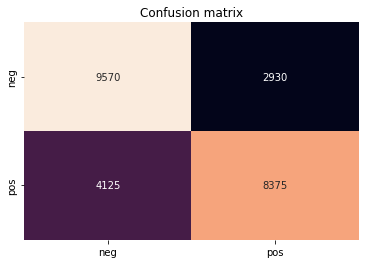

In [101]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Можно видеть, что при использовании *TfidfEmbeddingVectorizer* метрика Accuracy немного увеличилась по сравнению c *MeanEmbeddingVectorizer* $-$ с 0.60 до 0.62.

## Классификация с помощью FastText

Теперь попробуем классифицировать тексты с помощью другой языковой модели [FastText](https://github.com/facebookresearch/fasttext), которая также была описана в предыдущем занятии.

Чтобы использовать модель, подготовим для нее данные, записав тексты и их метки классов в файлы data.train.txt и text.txt

In [109]:
pip install fasttext  > /dev/null

In [110]:
import fasttext

N = -1

with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ ' '.join(X_train[i]) + '\n')
    

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + ' '.join(X_test[i]) + '\n')

Будем использовать встроенную в fasttext модель классификации (логистическая регрессия) с помощью метода train_supervised.

In [111]:
classifier = fasttext.train_supervised('data.train.txt')#, 'model')
result = classifier.test('test.txt')
print('P@1:', result[1])#.precision)
print('R@1:', result[2])#.recall)
print('Number of examples:', result[0])#.nexamples)

P@1: 0.50012
R@1: 0.50012
Number of examples: 25000


Precision:   0.75
Recall:   0.50
F1-measure:   0.33
Accuracy:   0.50
              precision    recall  f1-score   support

         neg       1.00      0.00      0.00     12500
         pos       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.75      0.50      0.33     25000
weighted avg       0.75      0.50      0.33     25000



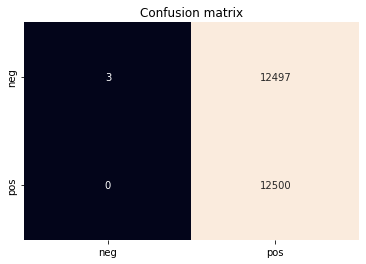

In [112]:
pred = classifier.predict([' '.join(x) for x in X_test])[0]
pred = [label[0].split("_")[-1] for label in pred]

print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))#[i[0] for i in pred]))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Можно видеть, что качество классификации при использовании FastText существенно увеличилось по сравнению с моделях на основе Word2Vec.

## Классификация с использованием CNN

Теперь попробуем применить нейросетевой подход.

Построим сверточную нейронную сеть (CNN) для классификации документов на позитивный и негативный классы.

In [113]:
!pip install spacy  > /dev/null

In [114]:
!python -m spacy download en
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 12.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [115]:
import spacy

en_nlp = spacy.load('en_core_web_sm')

Попробуем обучить простую CNN на векторах слов. С учётом того, что в коллекции 100К уникальных слов, и векторы получатся достаточно громоздкие, урежем коллекцию до 25К слов, для всех прочих заведя токен unk (unknown). Кроме того, разобьём обучающую выборку на обучение и валидацию для настройки параметров.

In [117]:
import random
train, valid = train_src.split(random_state=random.seed(SEED))

AttributeError: ignored

In [ ]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

Выше в словаре, помимо отсечения 25К наиболее частых слов, также появятся два специальных токена - unk и pad (padding).

Теперь создадим батчи, предварительно отсортировав тексты по длине, чтобы минимизировать вставки pad-токенов:

In [ ]:
BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

Опишем функцию подсчёта accuracy, а также функции обучения и применения сети:

In [ ]:
import torch.nn.functional as F

def binary_accuracy(preds, y):
    rounded_preds = torch.round(F.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train_func(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        
        predictions = model(batch.text.cuda()).squeeze(1)

        loss = criterion(predictions.float(), batch.label.float().cuda())
        acc = binary_accuracy(predictions.float(), batch.label.float().cuda())
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss
        epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate_func(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text.cuda()).squeeze(1)

            loss = criterion(predictions.float(), batch.label.float().cuda())
            acc = binary_accuracy(predictions.float(), batch.label.float().cuda())

            epoch_loss += loss
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Начнём с подготовки данных:

In [ ]:
TEXT.build_vocab(train, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train)


BATCH_SIZEBATCH_S  = 8

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

Для создания свёрточного слоя воспользуемся nn.Conv2d, in_channels в нашем случае один (текст), out_channels -- это число число фильтров и размер ядер всех фильтров. Каждый фильтр будет иметь размерность [n x размерность вектора], где n - размер обрабатываемой n-граммы.

Важно, что предложения имели длину не меньше размера самого большого из используемых фильтров (здесь это не страшно, поскольку в используемых данных нет текстов, состоящих из пяти и менее слов).

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [sent len, batch size]
        x = x.permute(1, 0)
                
        #x = [batch size, sent len]
        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

Cоздадим модель и загрузим предобученные модели векторных представлений:


In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [ ]:
TEXT.build_vocab(train, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

In [ ]:
BATCH_SIZE  = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

Используя определённые ранее функции, запустим обучение с оптимизатором Adam и оценим качество на валидации и тесте:

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.cuda()

In [ ]:
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate_func(model, valid_iterator, criterion)
    
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.3f}, Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
test_loss , test_acc = evaluate_func(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')

Можно видеть, что качество классификации после 5 эпох обучения стало немного выше, чем при использовании FastText.

## Итоги

На этом занятии мы рассмотрели задачу бинарной классификации текстов на примере отзывов IMDB.
Для решения этой задачи мы попробовали следующие модели:
1. Word2Vec + MeanEmbeddingVectorizer + RandomForest
2. Word2Vec + TfidfEmbediingVectorizer + RandomForest
3. FastText со встроенным классификатором
4. Glove + CNN

Наилучшее качество показала нейросетевая модель CNN.